## Предсказание стоимости жилья

Цель проекта- обучить модель линейной регрессии силами PySpark на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Для оценки качества модели используются метрики RMSE, MAE и R2.

# Подготовка данных

Импортируем необходимые для работы над проектом библиотеки и инициализируем Spark-сессию.

In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.stat import Statistics

In [32]:
pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022

spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

Данные, которые будем использовать в проекте, были собраны в рамках переписи населения в США. Каждая строка содержит агрегированную статистику о жилом массиве. Жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

Прочитаем содержимое файла с данными и выведем на экран типы данных, содержащихся в колонках датасета.

In [33]:
df = spark.read.load('/datasets/housing.csv', format='csv', inferSchema=True, header='true')
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [34]:
df.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Почти все колонки содержат численные значения, кроме 'ocean_proximity'- она содержит категориальные.

Изучим значения в колонках методом describe.

In [35]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


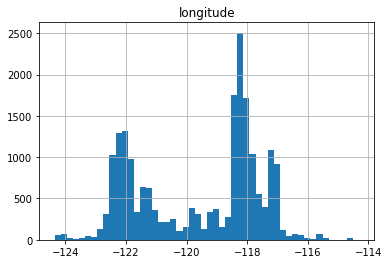

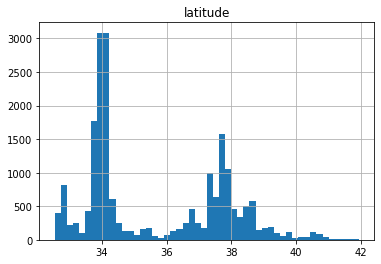

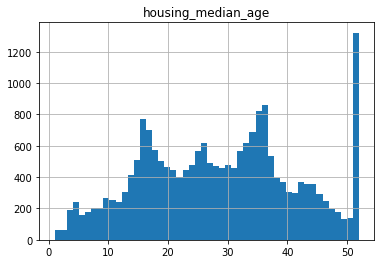

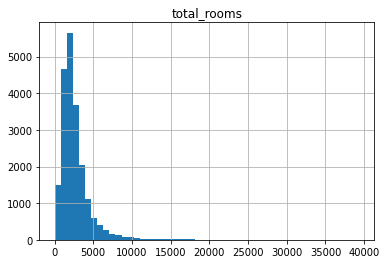

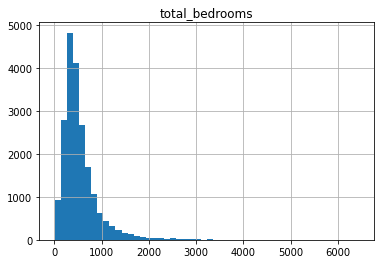

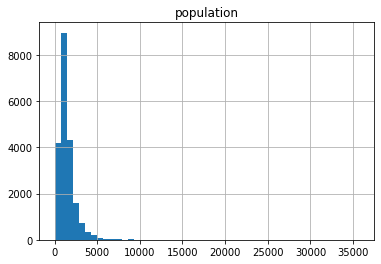

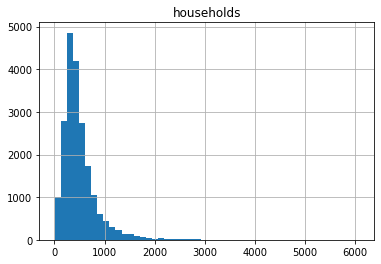

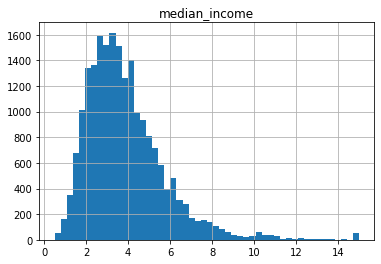

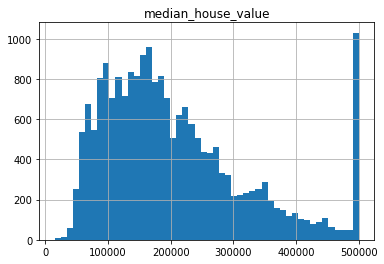

In [36]:
for column in ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 
               'population', 'households', 'median_income', 'median_house_value']:
    bins, counts = df.select(column).rdd.flatMap(lambda x: x).histogram(50)
    plt.hist(bins[:-1], bins=bins, weights=counts)
    plt.grid(True)
    plt.title(column)
    plt.show()

При изучении данных видим следующие особенности:
* в столбце с информацией о медианном возрасте жителей жилого массива 'housing_median_age' виден выброс в районе 52 лет. Возможно два варианта: либо при вводе данных допущены ошибки, либо в Калифорнии встречается довольно большое количество районов с пожилым населением. В пользу первой гипотезы говорит неравномерное распределение данных;
* в столбце с медианной ценой дома видим большое количество значений в районе 500000. Возможно, при вводе данных есть ограничение цены дома.

Выведем на экран количество дубликатов и количество пропусков во всех столбцах.

In [37]:
print('Количество дубликатов:', df.count() - df.distinct().count())

Количество дубликатов: 0


In [38]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



В столбце с количеством спален 207 пропусков. Для их заполнения необходимо выбрать метод. Для начала определим зависимость количества спален от общего количества комнат. Для этого выведем на экран гистограмму значений отношения общего количества комнат к количеству спален.

array([[<AxesSubplot:title={'center':'bedroom_index'}>]], dtype=object)

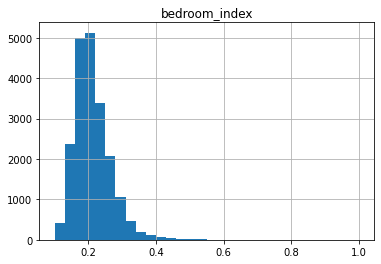

In [39]:
(df.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))
   .toPandas()
   .hist('bedroom_index', bins=30)
)

Большая часть значений лежит вокруг значения 0.2. Заполним пропуски в столбце 'total_bedrooms', умножив столбец 'total_rooms' на 0.2 и приведем значение к целому.

In [40]:
df_new = (df
           .withColumn('total_bedrooms', 
                       (F.when(F.col('total_bedrooms').isNull(), (F.col('total_rooms')*0.2).cast('int')))
                       .otherwise(F.col('total_bedrooms')))
         )

In [41]:
df_new.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Избавились от пропусков в данных.

Построим матрицу корреляции, чтобы определить, не коррелируют ли признаки друг с другом слишком сильно.

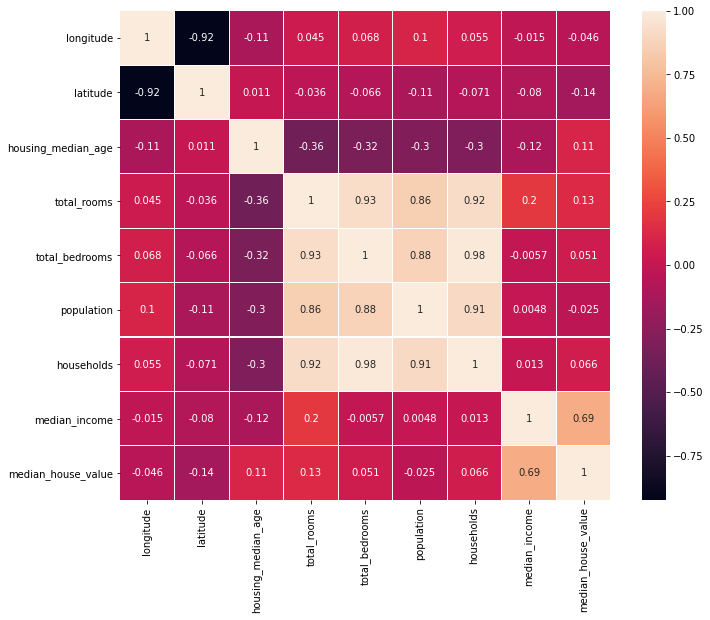

In [47]:
f, ax = plt.subplots(figsize=(11, 9))

features = df_new.rdd.map(lambda row: row[0:-1])
corr_mat=Statistics.corr(features, method="pearson")

sns.heatmap(corr_mat, annot=True, linewidths=.1, ax=ax)
plt.show()

Подготовим данные к машинному обучению: категориальные признаки преобразуем техникой OHE, а числовые признаки стандартизируем.

In [13]:
# Обработаем категориальные признаки методикой OHE
indexer = StringIndexer(inputCols=['ocean_proximity'], 
                        outputCols=['ocean_proximity_idx']) 
df_new = indexer.fit(df_new).transform(df_new)
encoder = OneHotEncoder(inputCols=['ocean_proximity_idx'],
                        outputCols=['ocean_proximity_ohe'])
df_new = encoder.fit(df_new).transform(df_new)

categorical_assembler = VectorAssembler(inputCols=['ocean_proximity_ohe'],
                                        outputCol="categorical_features")
df_new = categorical_assembler.transform(df_new)

In [14]:
# Выделим числовые признаки и стандартизируем

numerical_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
df_new = numerical_assembler.transform(df_new)

standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
df_new = standardScaler.fit(df_new).transform(df_new) 
all_features = ['categorical_features','numerical_features_scaled']

In [15]:
# Выделим отфильтрованные числовые признаки

filtered_numerical_cols = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

filtered_numerical_assembler = VectorAssembler(inputCols=filtered_numerical_cols, outputCol="filtered_numerical_features")
df_new = filtered_numerical_assembler.transform(df_new)

standardScaler = StandardScaler(inputCol='filtered_numerical_features', outputCol="filtered_features_scaled")
df_new = standardScaler.fit(df_new).transform(df_new) 

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 

df_all = final_assembler.transform(df_new)

final_assembler = VectorAssembler(inputCols=['categorical_features', 'filtered_features_scaled'], 
                                  outputCol="filt_features") 

df_all = final_assembler.transform(df_all)

Подготовили категориальные признаки для передачи модели машинного обучения.

Среди признаков наблюдается сильная корреляция в следующих столбцах:

* широта и долгота;
* общее количество комнат, количество спален, количество человек в жилом массиве и количество домовладений в жилом массиве;
* медианная заработная плата и целевой признак- медианная цена дома.

Целью учебного проекта является определение точности модели линейной регресси на количественных признаках с учетом и без учета категориального. Так как среди признаков наблюдается сильная корреляция дополнительно исключим такие признаки из набора и оценим точность модели также и на них.

Таким образом, произведем обучение модели на четырех наборах признаков:

* на всех признаках датасета с учетом категориального, обработанного методикой OHE;
* на всех количественных признаках без категориального;
* исключим из обучающего набора количество комнат, количество спален и количество домовладений, оставив только количество человек в жилом массиве, а также медианную заработную плату людей в жилом массиве;
* то же самое, но оставим медианную заработную плату. Так как этот признак сильно коррелирует с целевым, он может как привести к  хорошему результату, так и к переобучению модели.

In [16]:
df_all.select(F.col('features')).show(3) 

+--------------------+
|            features|
+--------------------+
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
|[0.0,0.0,0.0,1.0,...|
+--------------------+
only showing top 3 rows



Выделим целевой признак.

In [17]:
target = 'median_house_value'

Разделим данные на обучающую и тестовую выборки в соотношении 4:1.

In [18]:
train_data, test_data = df_all.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16418 4222


# Обучение моделей

Обучим модель линейной регрессии на полном наборе признаков.

In [19]:
def linear_regression(feauters_selection, features_name):
    lr = LinearRegression(labelCol=target, featuresCol=feauters_selection)
    model = lr.fit(train_data) 
    predictions = model.transform(test_data)
    rmse = RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(predictions)
    mae = RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(predictions)
    r_2 = RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(predictions)
    print(f"На выборке, включающей {features_name}, RMSE: {rmse: .1f}, MAE: {mae: .1f}, R2: {r_2: .3f}")

In [20]:
linear_regression('features', 'все признаки исходного датасета')

22/08/08 17:56:52 WARN Instrumentation: [a10af574] regParam is zero, which might cause numerical instability and overfitting.
22/08/08 17:56:53 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/08/08 17:56:53 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/08/08 17:56:53 WARN Instrumentation: [a10af574] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


На выборке, включающей все признаки исходного датасета, RMSE:  68487.1, MAE:  49813.5, R2:  0.654


Обучим модель линейной регрессии на наборе данных, исключая категориальные признаки.

In [21]:
linear_regression('numerical_features_scaled', 'включающей только числовые признаки')

22/08/08 17:56:59 WARN Instrumentation: [8f2bcc8f] regParam is zero, which might cause numerical instability and overfitting.


На выборке, включающей включающей только числовые признаки, RMSE:  69220.1, MAE:  50777.9, R2:  0.646


Обучим модель линейной регрессии на наборе данных, содержащем отфильтрованные числовые признаки.

In [22]:
linear_regression('filtered_features_scaled', 'только отфильтрованные числовые признаки')

22/08/08 17:57:04 WARN Instrumentation: [e7217d6e] regParam is zero, which might cause numerical instability and overfitting.


На выборке, включающей только отфильтрованные числовые признаки, RMSE:  75093.4, MAE:  54953.2, R2:  0.583


Обучим модель линейной регрессии на наборе данных, включающем категориальные признаки и отфильтрованные числовые признаки.

In [23]:
linear_regression('filt_features', 'категориальные признаки и отфильтрованные числовые признаки')

22/08/08 17:57:08 WARN Instrumentation: [ca9ef145] regParam is zero, which might cause numerical instability and overfitting.
22/08/08 17:57:09 WARN Instrumentation: [ca9ef145] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


На выборке, включающей категориальные признаки и отфильтрованные числовые признаки, RMSE:  69656.1, MAE:  50316.1, R2:  0.642


# Анализ результатов

По итогам проекта можем сделать следующие выводы:

1. В некоторых столбцах есть выбросы значений. Особенно много выбросов в столбцах с медианной ценой дома и с медианным возрастом жителей жилого массива. Фильтрация выбросов не привела к улучшению результата обучения модели линейной регрессии (фильтрация не отражена в тексте проекта, так как проводилась в большом количестве итераций и только ухудшала показатель R$^2$, видимо, критически снижая количество данных для обучения). Также в столбце с количеством спален было обнаружено небольшое количество пропусков, которые были заполнены исходя из предположения, что спален в 5 раз меньше, чем комнат в общем. 

2. Наилучший результат модель линейной регрессии показала на полном наборе данных, включая все числовые и категориальные признаки. R$^2$ на таком наборе данных получился равным 0.654, а модель в среднем ошибается в цене дома на 49813 долларов. Как было сказано выше, было несколько итераций расчетов, включающих в себя фильтрацию выбросов данных в столбцах с медианным возрастом жителей, медианной ценой дома и количеством проживающих в жилом массиве, а также с различным соотношением обучающей и тестовой выборок: 80 на 20, 75 на 25 и 85 на 15. Все эти итерации не отражены в тексте проекта, чтобы не увеличивать его объем. Наилучший результат показало разделение данных в соотношении 80 на 20 и включение всех признаков в обучающую выборку. 

3. С целью улучшения результата прогнозирования цены дома в жилом массиве можно предложить использование других, более сложных, моделей машинного обучения, например, модели решающего дерева, случайного леса, а при низких результатах на них- моделей градиентного бустинга.

По завершении проекта отключим спарк-сессию.

In [24]:
spark.stop()